In [1]:
#Importing relevant modules
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.exposure import equalize_adapthist

%matplotlib inline

<b>This section calibrates the camera</b>

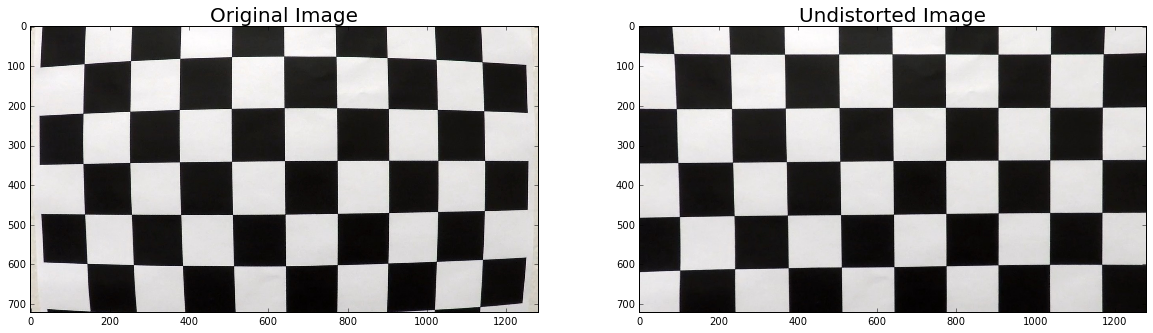

In [2]:
##Calibrating camera

file_names = glob.glob('camera_cal\calibration*.jpg')

##Calibrating camera
#Number of corners on chessboard
nx = 9
ny = 6

#List of object points and image points
objpoints = []
imgpoints = []

#Setting up objpoint coordinates 
objpoint = np.zeros((6*9,3), np.float32)
objpoint[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

#Reads image 
for file_name in file_names:
    image = mpimg.imread(file_name)

    #Convert image to gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    #Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    #Appending image points and object points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objpoint)
        
#Getting values for camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#Showing examples of original and undistorted images
distorted_example = mpimg.imread('camera_cal\calibration1.jpg')

#Undistort image
undistorted_image = cv2.undistort(distorted_example,mtx,dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(distorted_example)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=20)


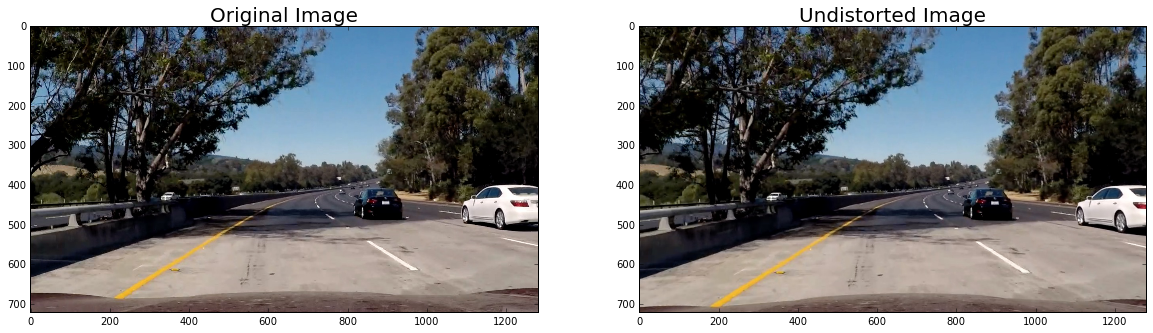

In [3]:
#Importing test images
test_image = mpimg.imread('test_images\\test5.jpg')
undistort_test_image =cv2.undistort(test_image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistort_test_image)
ax2.set_title('Undistorted Image', fontsize=20)

<b> This section obtains the color and gradient thresholds </b>

C:\Users\Michelle\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


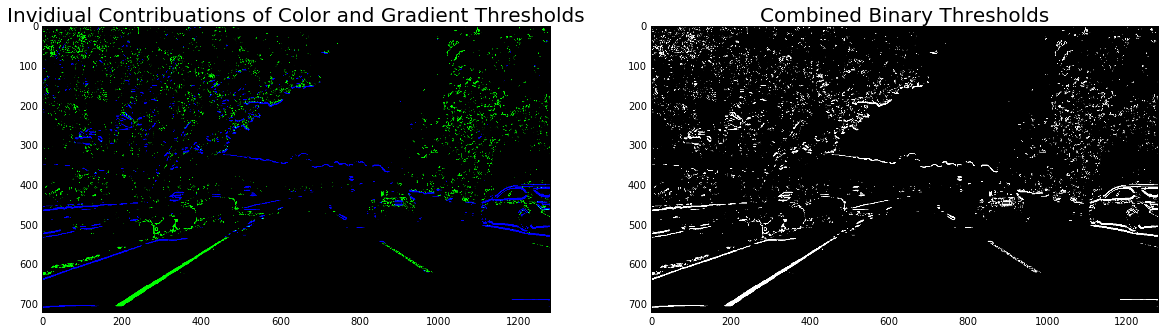

In [4]:
#Obtaining combined color/gradient threshold binary image

def color_grad(image, color_thresh = (0,255)):
    '''Returns binary output for saturation, red, greend color threshold'''
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls_image[:,:,2]
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= 175) & (s_channel <= 240)] = 1

    rgb_image = equalize_adapthist(np.copy(image))
    r_channel = rgb_image[:,:,0]
    g_channel = rgb_image[:,:,1]

    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel>=0.9) & (r_channel <.95) ] = 1
    
    g_binary = np.zeros_like(g_channel)
    g_binary[ (g_channel >= .85)] = 1

    combo = np.zeros_like(g_binary)
    combo[(r_binary==1)| (g_binary==1)| (s_binary ==1)]=1
    combo[(r_binary==1)| (s_binary ==1)]=1
    return s_binary

def dir_thresh(image, sobel_kernel=9, thresh=(0,np.pi/2)):
    '''Returns binary output for direction of gradient of undistorted image'''
    gray_test = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    sobel_x = cv2.Sobel(gray_test, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_test, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_gradient = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    
    binary_output_dir = np.zeros_like(abs_gradient)
    binary_output_dir[(abs_gradient >= thresh[0]) & (abs_gradient <= thresh[1])] = 1

    return binary_output_dir

def abs_mag_thresh(image, sobel_kernel=9, mag_thresh=(0, 255)):
    '''Returns binary output for absolute magnitude treshold of undistorted image'''
    gray_test = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    sobel_x = cv2.Sobel(gray_test, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_test, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_mag = np.sqrt(np.square(sobel_y) + np.square(sobel_x))
    
    mag_sobel_xy = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    scaled_mag_sobel_xy = np.uint8((255*mag_sobel_xy)/np.max(mag_sobel_xy))
    
    binary_output_mag = np.zeros_like(scaled_mag_sobel_xy)
    binary_output_mag[(scaled_mag_sobel_xy >= mag_thresh[0]) & (scaled_mag_sobel_xy <=mag_thresh[1])]= 1
    
    return binary_output_mag

def combined_binary_output(image,dir_kernel = 15, mag_kernel =15, thresh=(0.7,1.4), mag_thresh=(17,80),color_thresh = (0,255)):
    '''Takes binary thresholds and combines them into one image'''
    dir_binary = dir_thresh(image, sobel_kernel=dir_kernel, thresh= thresh)
    abs_binary = abs_mag_thresh(image, sobel_kernel=mag_kernel, mag_thresh=mag_thresh)
    color_binary = color_grad(image,color_thresh)
    
    combined_binary = np.zeros_like(color_binary)
    combined_binary[(color_binary ==1)|((dir_binary == 1) & (abs_binary == 1))] = 1
    
    return combined_binary

def show_contribution(image,dir_kernel = 15, mag_kernel =15, thresh=(0.7,1.4), mag_thresh=(17,80),color_thresh = (0,255)):
    '''Shows contribution of gradient thresholds and color thresholds'''
    dir_binary = dir_thresh(image, sobel_kernel=dir_kernel, thresh= thresh)
    abs_binary = abs_mag_thresh(image, sobel_kernel=mag_kernel, mag_thresh=mag_thresh)

    grad_binary = np.zeros_like(dir_binary)
    grad_binary[(dir_binary == 1) & (abs_binary == 1)] = 1
    
    color_binary = color_grad(image,color_thresh)
    
    contribution = np.dstack((np.zeros_like(dir_binary),color_binary,grad_binary))
    
    return contribution
    
contribution = show_contribution(undistort_test_image, dir_kernel=15, mag_kernel=15, thresh =(0.5,np.pi/2), mag_thresh = (80,200), color_thresh = (200,240)) 
combined_binary = combined_binary_output(undistort_test_image, dir_kernel=15, mag_kernel=15, thresh =(0.5,np.pi/2), mag_thresh = (80,200), color_thresh = (200,240))

f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.imshow(contribution)
ax1.set_title('Invidiual Contribuations of Color and Gradient Thresholds', fontsize=20)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined Binary Thresholds', fontsize=20)

<b> This section uses a perspective transform to warp the image to obtain a bird's eye view </b>

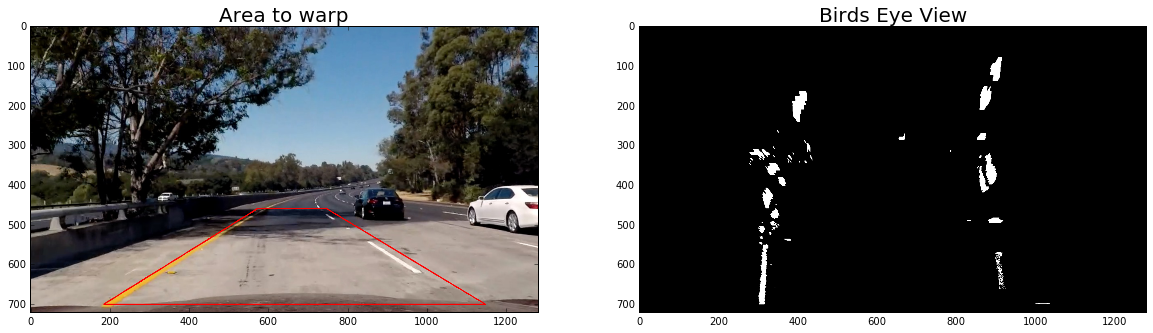

In [5]:
#This section of the code visualizes the perspective transform of a test image

#Performs perspective transform on image

def perspective_transform(image, inv = False):
    '''Performs perspective transform on an image. Source and destination points have been hard coded. Might not work for images from other cameras/position'''
    #Source points
    s_bottom_left = [185,700]
    s_bottom_right = [1200,692]
    s_top_right = [736,446]
    s_top_left = [592,446]
    
    source_points = np.float32([s_bottom_left, s_bottom_right, s_top_right, s_top_left])

    #Destination points
    d_bottom_left = [300,700]
    d_bottom_right = [1000,700]
    d_top_right = [1000,0]
    d_top_left = [300,0]

    destination_points = np.float32([d_bottom_left, d_bottom_right, d_top_right, d_top_left])
    
    #Perspective transform
    if inv == False:
        M = cv2.getPerspectiveTransform(source_points,destination_points)
    elif inv == True:
        M = cv2.getPerspectiveTransform(destination_points,source_points)
   
    copy_image = np.copy(image)
    
    #Determine image size for warping images
    if len(image.shape) == 3:
        img_size = image.shape[:2][::-1]
    elif len(image.shape) ==2:
        img_size = image.shape[::-1]
        
    #Warps image
    warped = cv2.warpPerspective(copy_image,M, img_size,flags=cv2.INTER_LINEAR)
    
    return warped

copy_test = np.copy(combined_binary)

#Masking images to only show region of interest
mask = np.zeros_like(copy_test)
ignore_mask_color = 255

#Defining four sided polygon to mask
vertices = np.array([[(170,700),(1250,692), (725,450), (580,450)]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(copy_test, mask)

binary_warped = perspective_transform(masked_edges)


#Plotting polygon on image for visualization
s_bottom_left = [185,700]
s_bottom_right = [1145,700]
s_top_right = [745,460]
s_top_left = [572,460]

pts = np.int32([s_bottom_left, s_bottom_right, s_top_right,s_top_left])
pts.reshape((-1,1,2))

mask_test = np.copy(undistort_test_image)
cv2.polylines(mask_test, [pts], True, (255,0,0),2)

#Plots masked imaged and bird's eye view image
f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.imshow(mask_test, cmap = 'gray' )
ax1.set_title('Area to warp', fontsize=20)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Birds Eye View', fontsize=20)

<b> In the following objectives are done </b>
<ul>
  <li>Use a histogram to find the number of line pixels</li>
  <li>Use a sliding search window to find left and right lines</li>
  <li>Perform a 2 degree polynomial fit to predict lines</li>
</ul> 

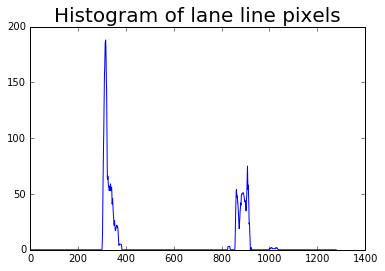

In [16]:
##This section of the code find left and right lane pixels. It then uses a polynomial fit to predict lane lines

#Find histogram from bottom half of image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.title('Histogram of lane line pixels', fontsize=20)

#Creates a color image from binary_warped to draw on
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

#Find midpoint of histogram and find index where maximum occurs for left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

#Set number of windows
nwindows = 9

#Set window height
window_height = np.int(binary_warped.shape[0]/nwindows)

#Find x and y position of non zero pixels in image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

#Current positions to update window
leftx_current = leftx_base
rightx_current = rightx_base

#Set width of window
margin = 100

#Set minimum pixel detected to recenter window
minpix = 10

#Empty lists to recieve left and right pixels
left_lane_inds = []
right_lane_inds = []

#For loop to step through each window

for window in range(nwindows):
    #Identify windows search boundaries in x and y
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    #Draw windows for visualization
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
    
    #Identify the nonzero pixels in x and y within a search window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    #Append good left and right indices to lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    #Recenters rectangle to their mean position if pixels found is more than minpix
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
#Concatenate array of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

#Extract left and right lane pixels' positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

#Least square second order polynomial fit
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx,2)



(720, 0)

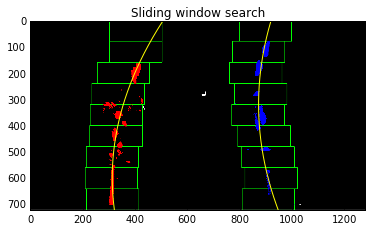

In [19]:
#Visualizing polynomial fit
#Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_line = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_line = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#Color in left and right line pixel
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds],nonzerox[right_lane_inds]] = [0, 0, 255]

#Plots image
plt.imshow(out_img)
plt.plot(left_line, ploty, color='yellow')
plt.plot(right_line, ploty, color='yellow')
plt.title('Sliding window search')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

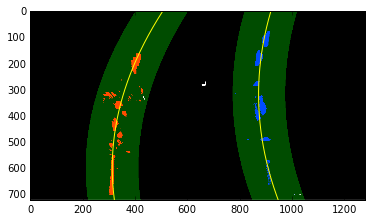

In [8]:
# Create an image to draw on and an image to show search window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

#Color in left and right line pixels
out_img[nonzeroy[left_lane_inds],nonzerox[left_lane_inds]] = [255,0,0]
out_img[nonzeroy[right_lane_inds],nonzerox[right_lane_inds]] = [0,0,255]

#Generate a polygon to illustrate the search window area
left_line_window1 = np.array([np.transpose(np.vstack([left_line-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_line-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_line, ploty, color='yellow')
plt.plot(right_line, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


<b> In this section, the car offset from center and the radius of lane curvature are found </b>

In [25]:
##Finds offset of car from center of road and radius of curvature of lane lines

line_seperation = np.mean(((right_line) + (left_line))/2)
ym_per_pix = 30/700 
xm_per_pix = 3.7/720 

#Find offset of car
center_offset = line_seperation - (binary_warped.shape[-1]//2)
car_offset = center_offset * xm_per_pix

#y_eval is the point there the radius of curvature is measure
y_eval = np.max(ploty)

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_line*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_line*xm_per_pix, 2)

# Radius of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
ave_curverad = (left_curverad + right_curverad)/2

car_offset = 'Car Offset: ' + '{0:.2f}'.format(car_offset) + 'm'
ave_curverad = 'Radius of Curvature:' + '{0:.2f}'.format(ave_curverad) + 'm'


<b> In this section, the predicted lane lines images are unwarped to plot lane on original image </b>

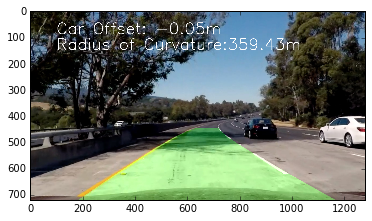

In [27]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_line, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = perspective_transform(color_warp, inv = True)

# Combine the result with the original image
result = cv2.addWeighted(undistort_test_image, 1, newwarp, 0.3, 0)
cv2.putText(result, car_offset , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=2)
cv2.putText(result, ave_curverad , (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=2)

plt.imshow(result)

<b> The following code is not used for this project. It will be used for future iterations to make the pipeline more efficient and robust </b>

In [ ]:
# ##Skipping sliding window after initial line has been found

# #Find x and y indices that are nonzero
# nonzero = binary_warped.nonzero()
# nonzeroy = np.array(nonzero[0])
# nonzerox = np.array(nonzero[1])

# margin = 100

# # Finds indices within margin of known line
# left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
# right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

# #Extract position of left and right lane lines
# leftx = nonzerox[left_lane_inds]
# lefty = nonzeroy[left_lane_inds]
# rightx = nonzerox[right_lane_inds]
# righty = nonzeroy[right_lane_inds]

# #Fit second order polynomial to positions
# left_fit = np.polyfit(lefty, leftx, 2)
# right_fit = np.polyfit(righty, rightx, 2)

# #Generate x and y value for plotting
# ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

